## Setup

In [ ]:
import os
from dotenv import load_dotenv
from src import util
import gc

import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score
import optuna
import joblib

In [2]:
load_dotenv()

slided_df_path = os.path.join(os.getenv("SLIDED_DFS_CSV_PATH"), "data_slided_V2.parquet")
target_column = "target_class_in_24h"

df_model_input = util.create_df_model_input_opt(slided_df_path, target_column, "xl_", '10min', 'last')

Colunas carregadas. Forma original (shape): (14780343, 30)
Iniciando resample...
Processamento concluído. Nova forma (shape): (1525392, 30)


In [3]:
df_model_input

,xl_mean_1h,xl_std_1h,xl_max_1h,xl_mean_6h,xl_std_6h,xl_max_6h,xl_mean_12h,xl_std_12h,xl_max_12h,xl_mean_24h,...,xl_max_30D,xl_deriv_5min,xl_deriv_15min,xl_deriv_30min,xl_deriv_1h,xl_deriv_3h,xl_deriv_6h,xl_deriv_12h,xl_deriv_24h,target_class_in_24h
ds,,,,,,,,,,,,,,,,,,,,,
1996-01-01 00:00:00,1.382000e-08,4.077036e-10,1.460000e-08,1.382000e-08,4.077036e-10,1.460000e-08,1.382000e-08,4.077036e-10,1.460000e-08,1.382000e-08,...,1.460000e-08,1.200000e-10,-2.222222e-11,-2.222222e-11,-2.222222e-11,-2.222222e-11,-2.222222e-11,-2.222222e-11,-2.222222e-11,0
1996-01-01 00:10:00,1.386000e-08,3.662039e-10,1.460000e-08,1.386000e-08,3.662039e-10,1.460000e-08,1.386000e-08,3.662039e-10,1.460000e-08,1.386000e-08,...,1.460000e-08,6.000000e-11,8.666667e-11,2.631579e-11,2.631579e-11,2.631579e-11,2.631579e-11,2.631579e-11,2.631579e-11,0
1996-01-01 00:20:00,1.465000e-08,1.199353e-09,1.690000e-08,1.465000e-08,1.199353e-09,1.690000e-08,1.465000e-08,1.199353e-09,1.690000e-08,1.465000e-08,...,1.690000e-08,-2.000000e-11,1.533333e-10,8.620690e-11,8.620690e-11,8.620690e-11,8.620690e-11,8.620690e-11,8.620690e-11,0
1996-01-01 00:30:00,1.500750e-08,1.278498e-09,1.760000e-08,1.500750e-08,1.278498e-09,1.760000e-08,1.500750e-08,1.278498e-09,1.760000e-08,1.500750e-08,...,1.760000e-08,-4.800000e-10,-8.000000e-11,5.333333e-11,3.589744e-11,3.589744e-11,3.589744e-11,3.589744e-11,3.589744e-11,0
1996-01-01 00:40:00,1.493600e-08,1.207757e-09,1.760000e-08,1.493600e-08,1.207757e-09,1.760000e-08,1.493600e-08,1.207757e-09,1.760000e-08,1.493600e-08,...,1.760000e-08,-4.200000e-10,-3.266667e-10,-5.333333e-11,-2.244898e-11,-2.244898e-11,-2.244898e-11,-2.244898e-11,-2.244898e-11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 23:10:00,1.741547e-05,8.155662e-06,2.906757e-05,8.042177e-06,7.965353e-06,2.906757e-05,5.907889e-06,6.032180e-06,2.906757e-05,5.112266e-06,...,2.230703e-04,-1.021528e-07,-2.112863e-07,-7.417230e-07,-3.695087e-07,1.130365e-08,6.214963e-09,2.687654e-09,-1.797753e-10,0
2024-12-31 23:20:00,1.386945e-05,8.019732e-06,2.906757e-05,8.102606e-06,7.935948e-06,2.906757e-05,5.934341e-06,6.025285e-06,2.906757e-05,5.111699e-06,...,2.230703e-04,5.006494e-08,-2.494649e-08,-2.282437e-07,-3.412356e-07,1.312784e-08,5.806479e-09,2.826751e-09,2.763174e-10,0
2024-12-31 23:30:00,1.089013e-05,7.042411e-06,2.906757e-05,8.168346e-06,7.906699e-06,2.906757e-05,5.967761e-06,6.017797e-06,2.906757e-05,5.114725e-06,...,2.230703e-04,6.857236e-08,5.889929e-08,-3.701955e-08,-2.430760e-07,1.692183e-08,8.116973e-09,3.689978e-09,3.642255e-10,0


In [4]:
great_filter_training_pool = df_model_input[df_model_input[target_column] > 0].copy()

In [5]:
train_pct = 0.7
val_pct = (1-train_pct)/2
test_pct = (1-train_pct)/2

great_filter_data = util.prepare_data(great_filter_training_pool, target_column, lambda lb: 1 if lb >= 3 else 0, train_pct, val_pct)

## Features Importance

In [6]:
great_filter_initial_model = joblib.load("../../models/great_filter/great_filter_model_v7.joblib")

In [7]:
feature_names = great_filter_data['x']['train'].columns

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': great_filter_initial_model.feature_importances_
}).sort_values('importance', ascending=False)

importance_df['cumulative_importance'] = importance_df['importance'].cumsum()

In [8]:
print("--- Tabela de Importância Acumulada ---")
print(importance_df.head(25))

--- Tabela de Importância Acumulada ---
           feature  importance  cumulative_importance
6      xl_mean_12h    0.096368               0.096368
10      xl_std_24h    0.078767               0.175135
9      xl_mean_24h    0.064891               0.240026
11      xl_max_24h    0.058144               0.298170
5        xl_max_6h    0.054940               0.353110
17      xl_max_14D    0.051260               0.404370
14       xl_max_7D    0.050660               0.455030
20      xl_max_30D    0.044652               0.499682
16      xl_std_14D    0.043610               0.543292
13       xl_std_7D    0.043604               0.586896
19      xl_std_30D    0.041295               0.628191
18     xl_mean_30D    0.041236               0.669427
12      xl_mean_7D    0.036047               0.705474
1        xl_std_1h    0.033971               0.739446
15     xl_mean_14D    0.033705               0.773151
0       xl_mean_1h    0.029516               0.802667
3       xl_mean_6h    0.029316            

In [9]:
THRESHOLD = 0.9

features_to_keep = importance_df[importance_df['cumulative_importance'] <= THRESHOLD]['feature'].tolist()

if len(features_to_keep) < 5:
    features_to_keep = importance_df['feature'].head(10).tolist()

print(f"\nNúmero original de features: {len(feature_names)}")
print(f"Número de features após corte de {THRESHOLD*100}%: {len(features_to_keep)}")
print("\nFeatures selecionadas:")
print(features_to_keep)


Número original de features: 29
Número de features após corte de 90.0%: 19

Features selecionadas:
['xl_mean_12h', 'xl_std_24h', 'xl_mean_24h', 'xl_max_24h', 'xl_max_6h', 'xl_max_14D', 'xl_max_7D', 'xl_max_30D', 'xl_std_14D', 'xl_std_7D', 'xl_std_30D', 'xl_mean_30D', 'xl_mean_7D', 'xl_std_1h', 'xl_mean_14D', 'xl_mean_1h', 'xl_mean_6h', 'xl_max_12h', 'xl_max_1h']


## Training and Parameter Tuning

In [10]:
great_filter_lean_data = {
    'x': {
        'train': great_filter_data['x']['train'][features_to_keep].copy(),
        'val':   great_filter_data['x']['val'][features_to_keep].copy(),
        'test':  great_filter_data['x']['test'][features_to_keep].copy()
    },
    'y': great_filter_data['y']
}

In [11]:
def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'n_estimators': 1000,
        'random_state': 1502,
        'n_jobs': -1,
        'early_stopping_rounds': 50,

        'device': 'cuda',

        'scale_pos_weight': trial.suggest_float("scale_pos_weight", 0.3, 3.0, log=True),

        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
    }

    model_ = xgb.XGBClassifier(**params)

    model_.fit(
        great_filter_lean_data['x']['train'],
        great_filter_lean_data['y']['train'],
        eval_set=[(great_filter_lean_data['x']['val'], great_filter_lean_data['y']['val'])],
        verbose=False
    )

    y_pred_val = model_.predict(great_filter_lean_data['x']['val'])

    recall_cmx = recall_score(great_filter_data['y']['val'], y_pred_val, pos_label=1)
    recall_ab = recall_score(great_filter_data['y']['val'], y_pred_val, pos_label=0)
    w_ab = 6.0
    w_cmx = 1.0
    score = (w_ab * recall_ab) + (w_cmx * recall_cmx)

    return score

In [12]:
study = optuna.create_study(direction='maximize')
print("\nIniciando o tuning para o 'Great Filter' (Modelo 2)...")
study.optimize(objective, n_trials=2000)

print("\nBusca concluída!")
print(f"Melhor valor: {study.best_value:.4f}")
print("Melhores parâmetros encontrados:")
print(study.best_params)

[I 2025-11-17 22:05:53,119] A new study created in memory with name: no-name-0b8606ea-6210-4f77-8e20-764fdb6ba81c



Iniciando o tuning para o 'Great Filter' (Modelo 2)...


C:\Users\Eduardo\BES\IC\Solar_Flares\.venv\Lib\site-packages\xgboost\core.py:774: UserWarning: [22:05:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
[I 2025-11-17 22:05:55,004] Trial 0 finished with value: 5.7450045097316895 and parameters: {'scale_pos_weight': 0.6983695424523574, 'max_depth': 9, 'learning_rate': 0.10865954183492835, 'subsample': 0.6354361916309611, 'colsample_bytree': 0.90723031914865, 'gamma': 4.554141669924985, 'min_child_weight': 10}. Best is trial 0 with value: 5.7450045097316895.
[I 2025-11-17 22:05:58,483] Trial 1 finished w


Busca concluída!
Melhor valor: 6.2427
Melhores parâmetros encontrados:
{'scale_pos_weight': 0.32395677595311184, 'max_depth': 3, 'learning_rate': 0.20588960629311107, 'subsample': 0.8799995423759813, 'colsample_bytree': 0.6546230624581424, 'gamma': 3.98243279595542, 'min_child_weight': 5}


In [13]:
great_filter_params = study.best_params

great_filter_params.update({
    'n_estimators': 1000,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'random_state': 1502,
    'n_jobs': -1,
    'early_stopping_rounds': 50
})

In [14]:
great_filter_model = xgb.XGBClassifier(**great_filter_params)

print("\nIniciando o treinamento do 'Great Filter' (Modelo 2)...")
great_filter_model.fit(
    great_filter_lean_data['x']['train'],
    great_filter_lean_data['y']['train'],
    eval_set=[(great_filter_lean_data['x']['val'], great_filter_lean_data['y']['val'])],
    verbose=100
)
print("Treinamento concluído.")


Iniciando o treinamento do 'Great Filter' (Modelo 2)...
[0]	validation_0-logloss:0.60755
[59]	validation_0-logloss:0.48529
Treinamento concluído.


## Results

--- Relatório de Classificação (Conjunto de Teste) ---

              precision    recall  f1-score   support

      AB (0)       0.57      0.73      0.64     11988
     CMX (1)       0.98      0.96      0.97    155749

    accuracy                           0.94    167737
   macro avg       0.77      0.84      0.80    167737
weighted avg       0.95      0.94      0.94    167737


--- Matriz de Confusão ---


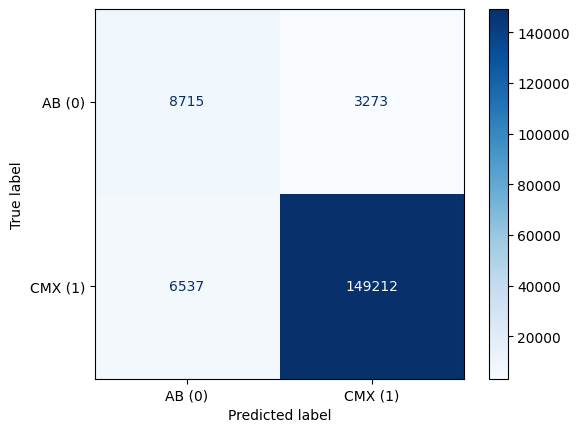

In [15]:
great_filter_y_pred = great_filter_model.predict(great_filter_lean_data['x']['test'])

print("--- Relatório de Classificação (Conjunto de Teste) ---\n")
print(classification_report(great_filter_lean_data['y']['test'], great_filter_y_pred, target_names=['AB (0)', 'CMX (1)']))

print("\n--- Matriz de Confusão ---")
cm = confusion_matrix(great_filter_lean_data['y']['test'], great_filter_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['AB (0)', 'CMX (1)'])
disp.plot(cmap='Blues')
plt.show()

## Evaluating Tradeoff cost

In [16]:
great_filter_lean_data['x'].keys()

dict_keys(['train', 'val', 'test'])

In [17]:
great_filter_y_multiclass = df_model_input[target_column]

val_end = int(len(df_model_input) * (val_pct + train_pct))
great_filter_y_multi_truth = great_filter_y_multiclass.iloc[val_end:]

In [18]:
df_analysis = pd.DataFrame(index=great_filter_lean_data['y']['test'].index)
df_analysis['binary_truth'] = great_filter_lean_data['y']['test']
df_analysis['binary_pred'] = great_filter_y_pred
df_analysis['multiclass_truth'] = great_filter_y_multi_truth

is_false_negative = (df_analysis['binary_truth'] == 1) & (df_analysis['binary_pred'] == 0)
df_false_negatives = df_analysis[is_false_negative]
print(f"Número total de Falsos Negativos encontrados: {len(df_false_negatives)}")

Número total de Falsos Negativos encontrados: 6537


In [19]:
df_false_negatives

,binary_truth,binary_pred,multiclass_truth
ds,,,
2021-10-09 00:20:00,1,0,4
2021-10-09 00:30:00,1,0,4
2021-10-09 00:40:00,1,0,4
2021-10-09 00:50:00,1,0,4
2021-10-09 02:00:00,1,0,4
...,...,...,...
2024-04-08 23:00:00,1,0,3
2024-04-08 23:10:00,1,0,3
2024-04-08 23:20:00,1,0,3


## Exporting Models

In [20]:
model_save_path = r'../../models/great_filter/great_filter_model_v9.joblib'
joblib.dump(great_filter_model, model_save_path)
print(f"Modelo salvo em {model_save_path}")

Modelo salvo em ../../models/great_filter/great_filter_model_v9.joblib
